In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
%%time
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

CPU times: total: 125 ms
Wall time: 151 ms


# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [3]:
df.sample(5)

,URL,Name
11054,https://raw.githubusercontent.com/spring-proje...,JAVA
31618,https://raw.githubusercontent.com/elastic/elas...,JAVA
3473,https://raw.githubusercontent.com/tensorflow/t...,PYTHON
34974,https://raw.githubusercontent.com/junit-team/j...,JAVA
12879,https://raw.githubusercontent.com/spring-proje...,JAVA


### Step 2: Number of Unique Values in all the columns

In [4]:
df.nunique()

URL     75124
Name        8
dtype: int64

In [5]:
df.describe()

,URL,Name
count,75124,75124
unique,75124,8
top,https://raw.githubusercontent.com/gap-system/g...,JAVA
freq,1,26768


### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['GAP', 'PYTHON', 'JAVA', 'JAVASCRIPT', 'TYPESCRIPT', 'GO', 'PHP',
       'RUBY'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [7]:
df['URL'].duplicated().sum()

0

### Step 5: Check the info() on the features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75124 entries, 0 to 75123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     75124 non-null  object
 1   Name    75124 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

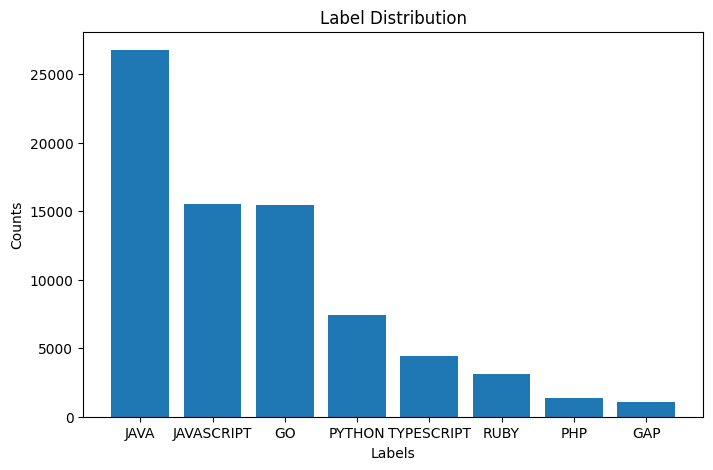

In [9]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

In [10]:
df["Name"].value_counts()

Name
JAVA          26768
JAVASCRIPT    15526
GO            15458
PYTHON         7393
TYPESCRIPT     4408
RUBY           3138
PHP            1379
GAP            1054
Name: count, dtype: int64

# Function to reduce the dataset

In [11]:
def reduce_dataset(df):
    labels = df["Name"].unique()
    new_df = pd.DataFrame()
    
    length = df[df["Name"] == "GAP"].shape[0]
    
    for label in labels:
        new_df = pd.concat([new_df, df[df["Name"] == label].sample(length)], ignore_index=True)
    
    return new_df

In [12]:
reduced_df = reduce_dataset(df)

# Class Distribution after reducing the dataset

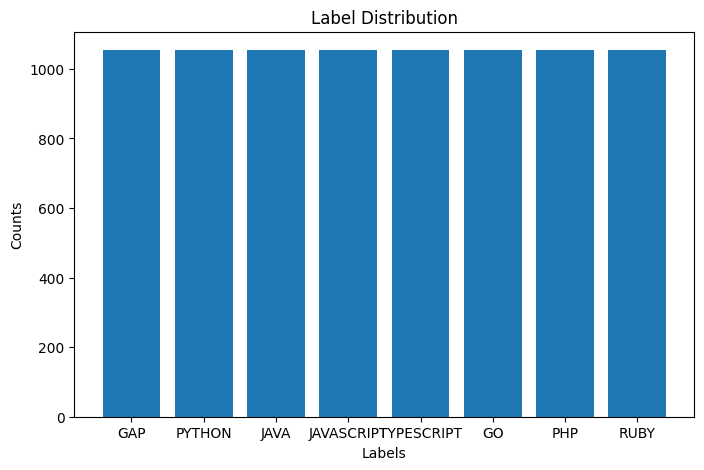

In [13]:
# Get the counts of unique labels within a column
label_counts = reduced_df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
# plt.xticks(rotation=90)
plt.title('Label Distribution')
plt.show()

In [14]:
reduced_df["Name"].value_counts()

Name
GAP           1054
PYTHON        1054
JAVA          1054
JAVASCRIPT    1054
TYPESCRIPT    1054
GO            1054
PHP           1054
RUBY          1054
Name: count, dtype: int64

# Function to remove non-ASCII characters from the given text

In [15]:
def remove_non_ascii(text):
    """
    Remove non-ASCII characters from the given text using a regular expression.
    """
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    return cleaned_text

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [16]:
import re
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file

# Custom transformer for case-folding
class CaseFoldingTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [x.lower() for x in X]

# Custom transformer for stop words removal
class StopWordsRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        stop_words_list = stopwords.words('english')
        return [' '.join([word for word in x.split() if word not in stop_words_list]) for x in X]
    
    # Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            while True:
                try:    
                    response = requests.get(url)
                    content = response.content
                    encoding = chardet.detect(content)
        
                    if encoding['encoding'] == "ISO-8859-1":
                        decoded_content = content.decode("iso-8859-1")
                    elif encoding['encoding'] == "GB2312":
                        decoded_content = content.decode("GB2312")
                    else:
                        decoded_content = content.decode("utf-8")

                    # Remove non-ASCII characters from the decoded content
                    cleaned_content = remove_non_ascii(decoded_content)
                    
                    transformed_X.append(cleaned_content)
                    break
                except Exception as e:
                    print(url)
                    decoded_content = content.decode("utf-8")
                    cleaned_content = remove_non_ascii(decoded_content)
                    transformed_X.append(cleaned_content)
                    break
        return transformed_X


# Create a Pipeline for the basic text pre-processing

In [17]:
from sklearn.pipeline import Pipeline

# Define the preprocessing steps
pipeline_preprocessing = Pipeline([
#     ('case_folding', CaseFoldingTransformer()),
#     ('stop_words_removal', StopWordsRemovalTransformer()),
    ('url_to_content', UrlToContentTransformer()),
    ('number_removal', NumberRemovalTransformer()),
])

#### Apply the preprocessing pipeline to the dataset

In [18]:
%%time
reduced_df['Content'] = pipeline_preprocessing.fit_transform(reduced_df['URL'])

CPU times: total: 1min 38s
Wall time: 38min 22s


#### Visualise the datset after the preprocessing pipeline

In [19]:
reduced_df['Content']

0       K := function(G)\n  local n, AE,det,M,diag;\n ...
1       ##############################################...
2       ##############################################...
3       ##############################################...
4       ##############################################...
                              ...                        
8427    # frozen_string_literal: true\n\nrequire "abst...
8428    # frozen_string_literal: true\n\nmodule Action...
8429    # frozen_string_literal: true\n\nmodule Active...
8430    # frozen_string_literal: true\n\nrequire "acti...
8431    # frozen_string_literal: true\n\nrequire "isol...
Name: Content, Length: 8432, dtype: object

# Seperate the dataset into Independent and target variables

In [20]:
X = reduced_df['Content']
y = reduced_df['Name']

# Train-Test-Validation split

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training set (80%) and temporary set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation set (10%) and final training set (90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

# NLP techniques

- #### Bag-of-Words (CountVectorizer)
- #### n-grams
- #### TF-IDF
- ##### Byte-Pair Encoding

In [22]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tokenizers import ByteLevelBPETokenizer

#### Custom Transformer for  Byte-Pair Encoding

In [23]:
class BPEVectorizer:
    def __init__(self):
        self.tokenizer = ByteLevelBPETokenizer()

    def fit(self, X, y=None):
        texts = [text for text in X]
        self.tokenizer.train(files=texts, special_tokens=["<s>", "<pad>", "</s>", "<unk>"])
        return self

    def transform(self, X):
        encoded_texts = [self.tokenizer.encode(text).ids for text in X]
        return encoded_texts

# Hyper-Parameter Tuning using GridSearchCV

#### Define a list of NLP techniques (vectorizers) with their hyperparameter grids

In [24]:
vectorizers = [
    (CountVectorizer(), {
        'vectorizer__max_features': [1000, 2000, 3000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)]
    }),
    
    (TfidfVectorizer(), {
        'vectorizer__max_df': [0.8, 0.9, 1.0],
        'vectorizer__min_df': [1, 2, 3],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__use_idf': [True, False],
    }),
    
    (BPEVectorizer(), {}),
]

#### Define a list of classifiers with their hyperparameter grids

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

classifiers = [
    (LogisticRegression(), {'clf__C': [0.1, 1, 10], 'clf__max_iter': [500, 1000]}),
    (MultinomialNB(), {'clf__alpha': [0.1, 1, 10]}),
    (SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    (RandomForestClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20]})
]

In [26]:
# scoring = {
#     'accuracy': 'accuracy',          
#     'precision_macro': 'precision_macro',
#     'recall_macro': 'recall_macro',
#     'f1_macro': 'f1_macro'
# }

#### Perform GridSearchCV for hyperparameter tuning for all combinations

In [27]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

best_model = None
best_f1_score = 0

for vectorizer, vectorizer_params in vectorizers:
    for classifier, classifier_params in classifiers:
#         for metric_name, scoring_metric in scoring.items():
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('clf', classifier)
        ])

        param_grid = {**vectorizer_params, **classifier_params}

        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=make_scorer(f1_score, average='weighted'))
        grid_search.fit(X_train, y_train)

        score = grid_search.best_score_

        print(f"Vectorzier: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}")
        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1-Score:", score)
        print()
        

        if score > best_f1_score:
            best_f1_score = score
            best_model = grid_search.best_estimator_


Vectorzier: CountVectorizer, Classifier: LogisticRegression
Best Hyperparameters: {'clf__C': 0.1, 'clf__max_iter': 500, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Best F1-Score: 0.9804746006646983

Vectorzier: CountVectorizer, Classifier: MultinomialNB
Best Hyperparameters: {'clf__alpha': 0.1, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Best F1-Score: 0.9679495617971673

Vectorzier: CountVectorizer, Classifier: SVC
Best Hyperparameters: {'clf__C': 0.1, 'clf__kernel': 'linear', 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}
Best F1-Score: 0.9613641541072673

Vectorzier: CountVectorizer, Classifier: RandomForestClassifier
Best Hyperparameters: {'clf__max_depth': None, 'clf__n_estimators': 100, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 1)}
Best F1-Score: 0.9909624784973932

Vectorzier: TfidfVectorizer, Classifier: LogisticRegression
Best Hyperparameters: {'clf__C': 1, 'clf__max_iter': 500, 'vec

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 952, in _fit_transform_one
    res = transformer.fit(X, y, **fit_params).transform(X)
  File "C:\Users\kiran\AppData\Local\Temp\ipykernel_27488\923432738.py", line 7, in fit
    self.tokenizer.train(files=texts, special_tokens=["<s>", "<pad>", "</s>", "<unk>"])
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\tokenizers\implementations\byte_level_bpe.py", line 98, in train
    self._tokenizer.train(files, trainer=trainer)
Exception: The filename, directory name, or volume label syntax is incorrect. (os error 123)

--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 370, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\sklearn\pipeline.py", line 952, in _fit_transform_one
    res = transformer.fit(X, y, **fit_params).transform(X)
  File "C:\Users\kiran\AppData\Local\Temp\ipykernel_27488\923432738.py", line 7, in fit
    self.tokenizer.train(files=texts, special_tokens=["<s>", "<pad>", "</s>", "<unk>"])
  File "C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks\ML-GAP-Classification\lib\site-packages\tokenizers\implementations\byte_level_bpe.py", line 98, in train
    self._tokenizer.train(files, trainer=trainer)
Exception: The filename or extension is too long. (os error 206)


In [28]:
best_model

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1000)),
                ('clf', RandomForestClassifier())])

# Cross-Validation

In [29]:
# from sklearn.model_selection import cross_val_score

# # Specify the number of folds
# num_folds = 5

# accuracy_scores = cross_val_score(best_model, X, y, cv=num_folds, scoring='accuracy')
# print(np.mean(accuracy_scores))

# Evaluate the model

### Prection on test data

In [30]:
y_pred = best_model.predict(X_test)

### Step 1: Accuracy

In [31]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.991701244813278


### Step 2: Precision

In [32]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print(precision)

0.9917703903453902


### Step 3: Recall

In [33]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='weighted')
print(recall)

0.991701244813278


### Step 4: F1-score

In [34]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9917153924780605


### Step 5: Classfication Report (Summary of steps 1-4)

In [35]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         GAP       0.98      0.99      0.98       221
          GO       1.00      0.99      0.99       228
        JAVA       1.00      0.99      1.00       216
  JAVASCRIPT       1.00      0.99      0.99       202
         PHP       0.99      1.00      1.00       196
      PYTHON       0.98      0.99      0.98       211
        RUBY       1.00      1.00      1.00       204
  TYPESCRIPT       0.99      1.00      0.99       209

    accuracy                           0.99      1687
   macro avg       0.99      0.99      0.99      1687
weighted avg       0.99      0.99      0.99      1687



### Step 6: Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

#### Plot Confusion Matrix

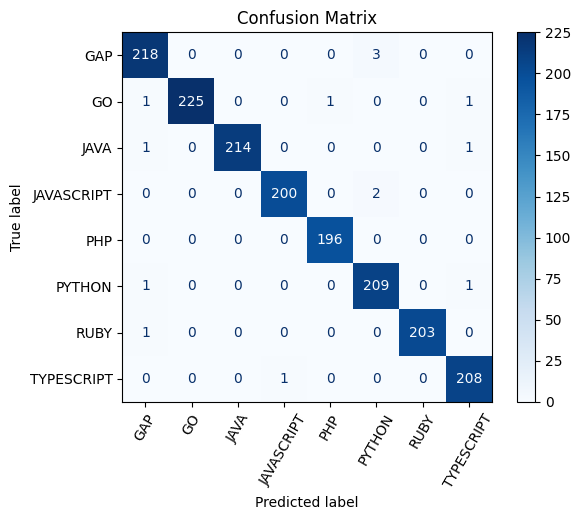

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.xticks(rotation=60)
plt.show()

### Step 7: ROC-Curve (Can be used if the labels become:- "GAP" & "Others")

In [38]:
# from sklearn.metrics import roc_curve, roc_auc_score

# # Compute ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred)

#### Plot ROC curve

In [39]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='b')
# plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# Save the model

In [40]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks
C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub


In [44]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('pipeline_preprocessing', pipeline_preprocessing),
    ('classifier_and_vectorizer', best_model)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whether working or not

In [45]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

# Prediction

In [46]:
predictions

array(['JAVA'], dtype=object)